In [ ]:
%pip install pandas matplotlib tensorflow scikit-learn keras numpy

In [12]:
# check if the data is available in the path of './data/'
import os
if 'kaggle' in os.listdir('/'):
    print('Kaggle environment')
    data_path = '/kaggle/input/predict-student-performance-from-game-play/'
else:
    data_path = './data/'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./data/train_labels.csv
./data/.DS_Store
./data/test.csv
./data/train.csv
./data/sample_submission.csv
./data/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
./data/jo_wilder/__init__.py
./data/jo_wilder_310/__init__.py
./data/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so


## Background

### Features
* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

### The labels
* The label rows have two columns, `session_id` and `correct`
* The `session_id` column format as `<session_id>_q<question #>`. Each session will have 18 rows, representing 18 questions.
* The `correct` column have the value 1 or 0 for all 18 questions for each session in the training set


## Data preprocessing

In [19]:
import pandas as pd
train_data = pd.read_csv(data_path + "train.csv")
print(train_data.shape)
train_data.head()

(26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [20]:
# Load the train labels
train_labels = pd.read_csv(data_path + "train_labels.csv")
train_labels.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [21]:
# The label rows are identified with <session_id>_q<question #>. 
# Each session will have 18 rows, representing 18 questions.
# The label is the correct value for answer of the question.
# Extract the session_id and question number from the label rows.
train_labels[['session_id', 'question']] = train_labels['session_id'].str.split('_q', expand=True)
train_labels['question'] = train_labels['question'].astype(int)
train_labels['correct'] = train_labels['correct'].astype(int)
train_labels['session_id'] = train_labels['session_id'].astype(int)
train_labels.head()

,session_id,correct,question
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


### Visualizing the labels

<Axes: xlabel='correct'>

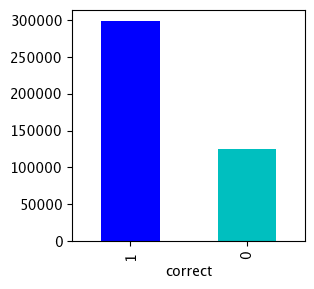

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plot_df = train_labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

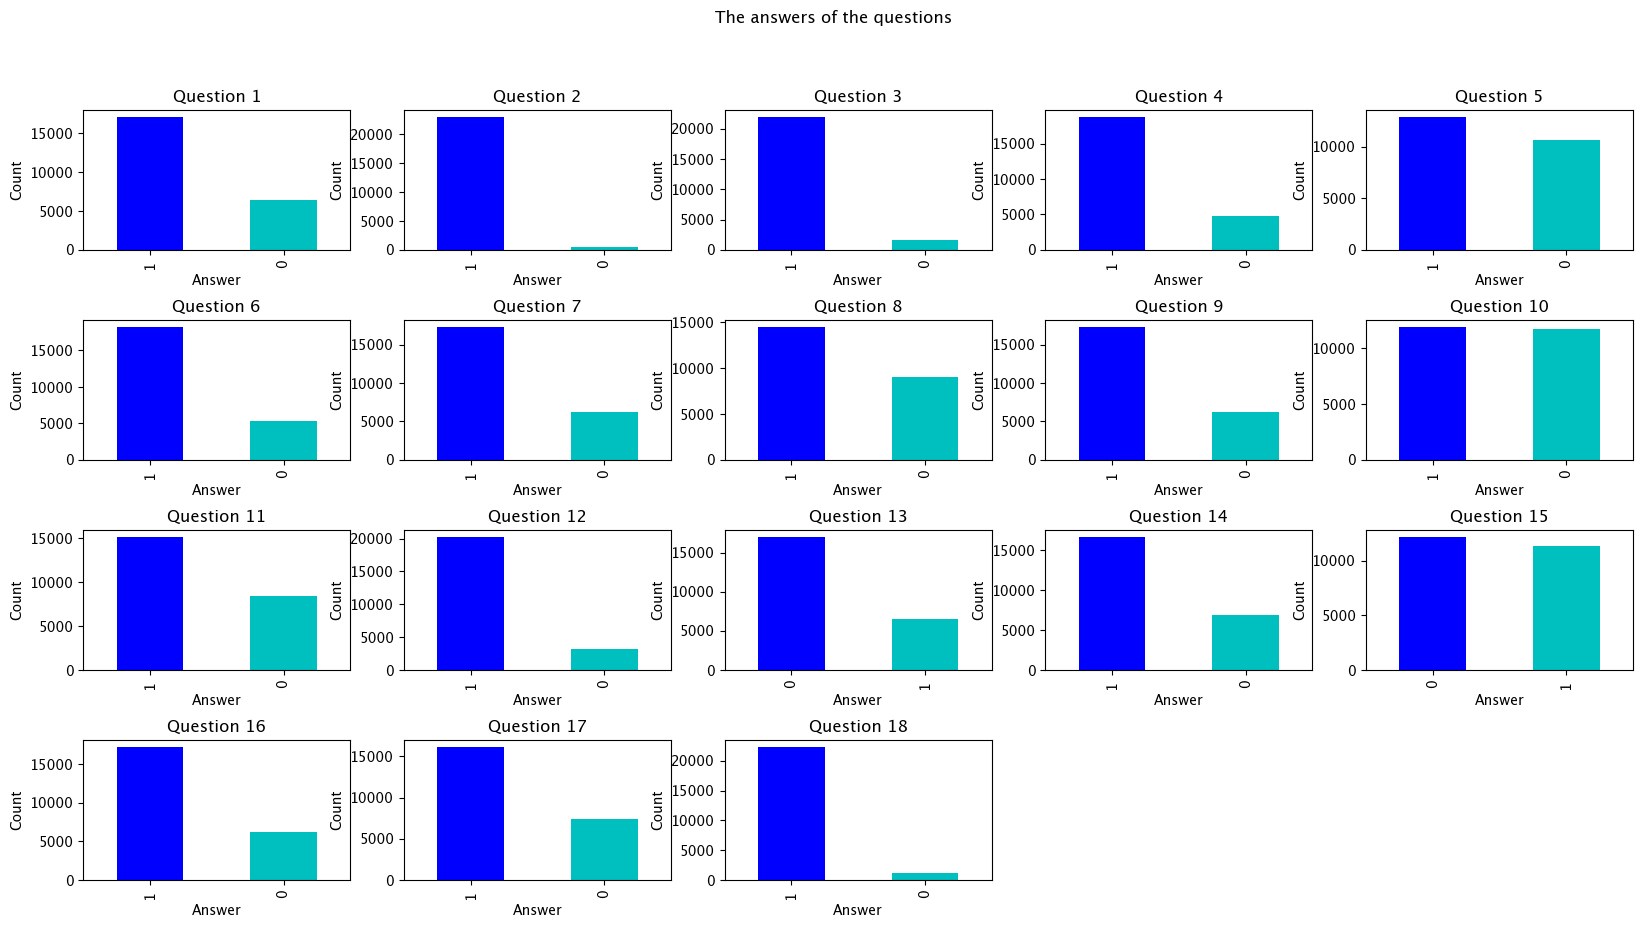

In [24]:
# Show the distribution of the answers of the questions in the train labels in 4 row, 5 columns
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('The answers of the questions')
for i in range(18):
    plt.subplot(4, 5, i+1)

    # filter data and plot ticker on the subplot axis
    plot_df = train_labels.loc[train_labels['question'] == i+1]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(kind="bar", color=['b', 'c'])
    
    plt.title('Question ' + str(i+1))
    plt.xlabel('Answer')
    plt.ylabel('Count')

## Spliting dataset

In [25]:
# Split the train data into train and validation data base on the session_id into different groups
from sklearn.model_selection import train_test_split

# Get the unique session_ids
train_data.index = train_data['session_id']
session_ids = train_data.index.unique()

# Use train_test_split to split the unique session_ids
train_ids, test_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

# Use the split session_ids to create the train and test datasets
X_train_, X_val_ = train_data.loc[train_ids], train_data.loc[test_ids]

print('Train data shape:', X_train_.shape)
print('Validation data shape:', X_val_.shape)

Train data shape: (20996063, 20)
Validation data shape: (5300883, 20)


## Feature engineering

In [26]:
X_train_.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
session_id,,,,,,,,,,,,,,,,,,,,
20100311260350376,20100311260350376,0,0,cutscene_click,basic,0,NaN,-191.991405,-228.314686,602.0,563.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20100311260350376,20100311260350376,1,202,cutscene_click,basic,0,NaN,-180.991405,-217.314686,613.0,552.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20100311260350376,20100311260350376,2,792,cutscene_click,basic,0,NaN,-174.991405,-100.314686,619.0,435.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20100311260350376,20100311260350376,3,1569,person_click,basic,0,NaN,-222.991405,-64.314686,571.0,399.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
20100311260350376,20100311260350376,4,2097,person_click,basic,0,NaN,-279.991405,-35.314686,514.0,370.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [ ]:
X_train_.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,2.099606e+07,2.099606e+07,2.099606e+07,2.099606e+07,450332.000000,1.933742e+07,1.933742e+07,1.933742e+07,1.933742e+07,1.601824e+06,2.099606e+07,2.099606e+07,2.099606e+07
mean,2.113154e+16,6.361660e+02,3.992325e+06,1.218945e+01,3.169924,-5.513074e+01,-1.161966e+02,4.584695e+02,3.857929e+02,3.564647e+03,1.389599e-01,1.207619e-01,9.288795e-01
std,5.725158e+14,4.464126e+02,3.122345e+07,6.497577e+00,2.062522,5.201695e+02,2.184040e+02,2.481250e+02,1.300919e+02,4.858337e+05,3.459047e-01,3.258504e-01,2.570260e-01
min,2.009031e+16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181623e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.101022e+16,2.870000e+02,4.404980e+05,6.000000e+00,1.000000,-3.529738e+02,-2.127073e+02,2.690000e+02,3.040000e+02,9.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.104021e+16,5.930000e+02,1.015072e+06,1.300000e+01,3.000000,-1.134850e+01,-9.761030e+01,4.470000e+02,3.970000e+02,4.190000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.110052e+16,8.940000e+02,1.744159e+06,1.800000e+01,5.000000,2.961775e+02,2.254006e+01,6.630000e+02,4.710000e+02,1.267000e+03,0.000000e+00,0.000000e+00,1.000000e+00
max,2.210022e+16,5.475000e+03,1.988607e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08,1.000000e+00,1.000000e+00,1.000000e+00


In [27]:
QUESTION_COUNT = 18
NUMERICAL_FEATURES = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINARY_FEATURES = ['fullscreen', 'hq', 'music']
CATEGORICAL_FEATURES = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid', 'text']

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Feature engineering for the train data
def feature_engineering(data):
    # Drop the 'session_id' column if it exists as we are using the index as session_id
    if 'session_id' in data.columns:
        data = data.drop(columns=['session_id'])
    
    # Convert the categorical features with grouping by the index session_id and level_group
    # And aggregate the data with the unique values and add the new features
    for feature in CATEGORICAL_FEATURES:
        # Convert the feature to string and group by the session_id and level_group
        data[feature] = data[feature].astype(str)
        data[feature] = data.groupby(['session_id', 'level_group'])[feature].transform('nunique')
        # Use the LabelEncoder to encode the categorical features
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
        
    # Process the numerical features 
    # Fill the missing values with 0 and normalize the data
    scaler = StandardScaler()
    data[NUMERICAL_FEATURES] = scaler.fit_transform(data[NUMERICAL_FEATURES])

    # Map the 3 level_group ('0-4', '5-12', '13-22') to int values
    data['level_group'] = data['level_group'].map({'0-4': 0, '5-12': 1, '13-22': 2})

    # Fill the missing values with -1
    data = data.fillna(-1)

    return data

In [32]:
# Apply the feature engineering to the train data
X_train = feature_engineering(X_train_)
X_val = feature_engineering(X_val_)

print('Train data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)
X_train.head()

Train data shape: (20996063, 19)
Validation data shape: (5300883, 19)


,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
session_id,,,,,,,,,,,,,,,,,,,
20100311260350376,0,-0.127863,3,0,-1.876,-1.0,-0.263108,-0.513352,0.578460,1.362168,-1.0,11,5,1,4,0,0,1,0
20100311260350376,1,-0.127857,3,0,-1.876,-1.0,-0.241961,-0.462987,0.622793,1.277613,-1.0,11,5,1,4,0,0,1,0
20100311260350376,2,-0.127838,3,0,-1.876,-1.0,-0.230426,0.072718,0.646974,0.378248,-1.0,11,5,1,4,0,0,1,0
20100311260350376,3,-0.127813,3,0,-1.876,-1.0,-0.322704,0.237550,0.453523,0.101521,-1.0,11,5,1,4,0,0,1,0
20100311260350376,4,-0.127796,3,0,-1.876,-1.0,-0.432283,0.370332,0.223800,-0.121398,-1.0,11,5,1,4,0,0,1,0


In [82]:
X_val.head()

,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
session_id,,,,,,,,,,,,,,,,,,,
22010107585684490,0,-0.130765,9,3,-1.877405,-1.0,-0.360952,0.264966,0.379556,0.06396,-1.0,undefined,24,6,15,0,0,1,0
22010107585684490,1,-0.130690,9,3,-1.877405,-1.0,-0.360952,0.264966,0.379556,0.06396,-1.0,"Whatcha doing over there, Jo?",24,6,15,0,0,1,0
22010107585684490,2,-0.130679,9,3,-1.877405,-1.0,-0.360952,0.264966,0.379556,0.06396,-1.0,Just talking to Teddy.,24,6,15,0,0,1,0
22010107585684490,3,-0.130480,9,3,-1.877405,-1.0,-0.360952,0.264966,0.379556,0.06396,-1.0,I gotta run to my meeting!,24,6,15,0,0,1,0
22010107585684490,4,-0.130446,9,3,-1.877405,-1.0,-0.360952,0.264966,0.379556,0.06396,-1.0,Meetings are BORING!,24,6,15,0,0,1,0


### Visualizing the data

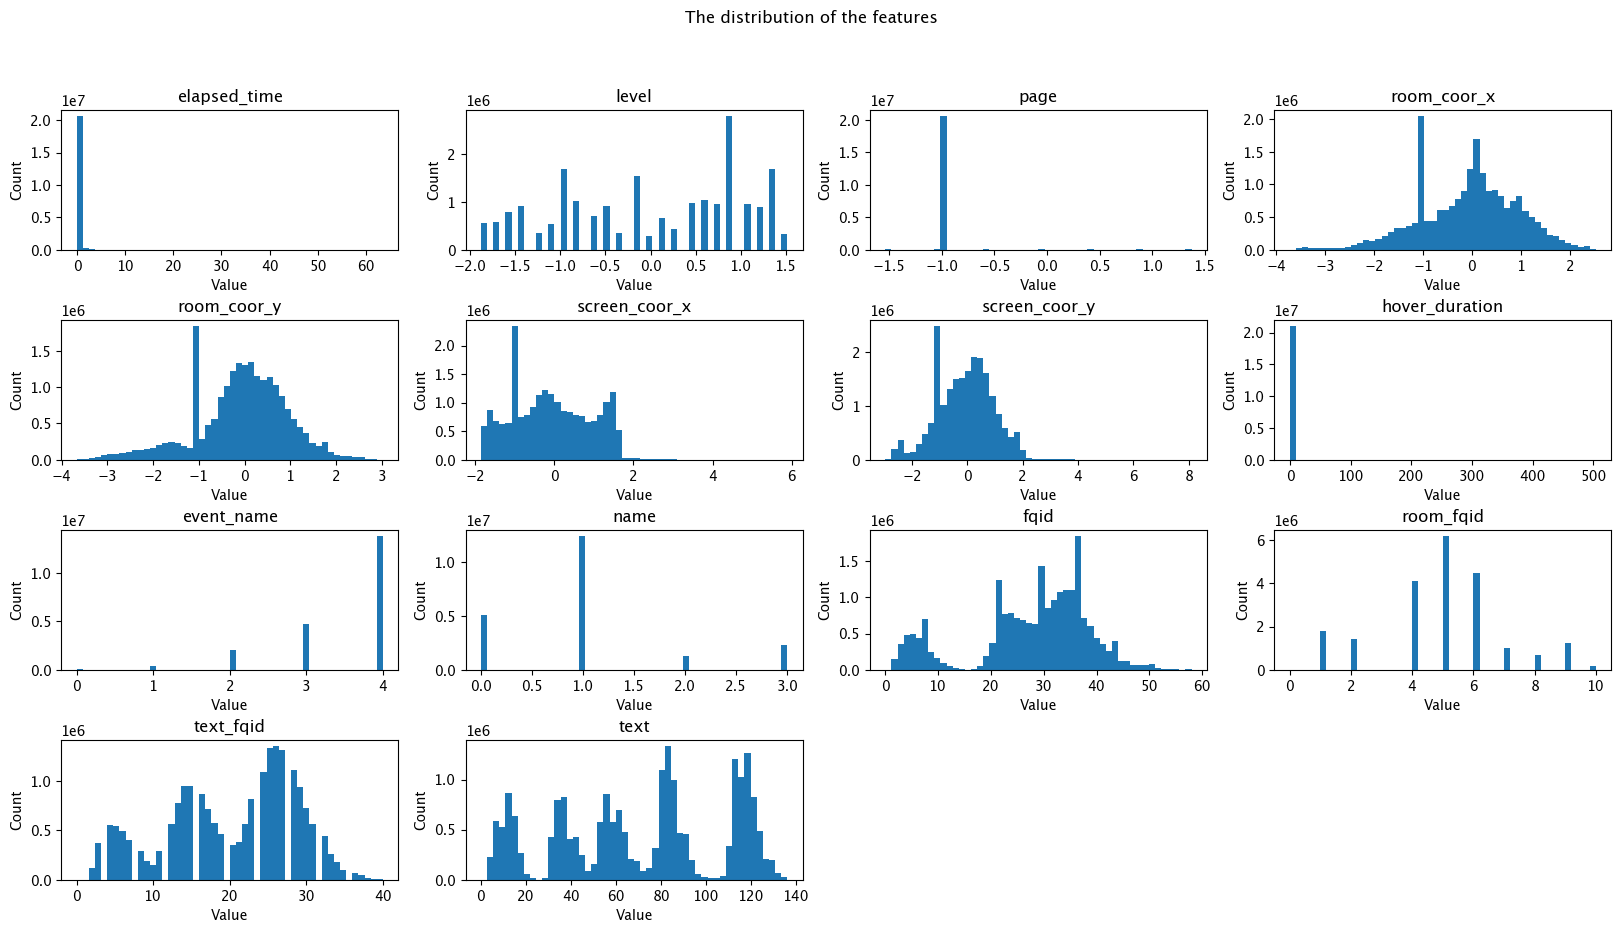

In [33]:
# Graph the distribution of the features
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('The distribution of the features')
for i, feature in enumerate(NUMERICAL_FEATURES + CATEGORICAL_FEATURES):
    plt.subplot(4, 4, i+1)
    X_train[feature].plot(kind="hist", bins=50)
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Count')

## Training the model

In [39]:
# Train the model with gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# For each question train a model
models = {}
for i in range(1, 18+1):
    print('=====================================')
    # Map the question number to the level group (0-4, 5-12, 13-22)
    level_group = 0 if i <= 4 else 1 if i <= 12 else 2
    print('Train model for question', i, 'with level group', level_group)


    # Filter the train data with the level group
    X_train_lg = X_train[X_train['level_group'] == level_group]
    X_train_session_ids = X_train_lg.index.values
    X_val_lg = X_val[X_val['level_group'] == level_group]
    X_val_session_ids = X_val_lg.index.values
    # drop the level_group column
    X_train_lg = X_train_lg.drop(columns=['level_group'])
    X_val_lg = X_val_lg.drop(columns=['level_group'])

    # Filter the train labels with the question number and session ids
    y_train = train_labels.loc[train_labels['question'] == i].set_index('session_id').loc[X_train_session_ids]
    y_train = y_train['correct']
    y_val = train_labels.loc[train_labels['question'] == i].set_index('session_id').loc[X_val_session_ids]
    y_val = y_val['correct']

    # Train the model
    model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2, max_depth=2, random_state=42)
    model.fit(X_train_lg, y_train)

    # Predict the validation data
    y_pred = model.predict(X_val_lg)
    accuracy = accuracy_score(y_val, y_pred)
    print('Accuracy for question', i, 'is', accuracy)
    models[i] = model


Train model for question 1 with level group 0
Accuracy for question 1 is 0.7103679071865678
Train model for question 2 with level group 0
Accuracy for question 2 is 0.9742948580968698
Train model for question 3 with level group 0
Accuracy for question 3 is 0.9195930164990271
Train model for question 4 with level group 0
Accuracy for question 4 is 0.7739409594003717
Train model for question 5 with level group 1
Accuracy for question 5 is 0.5822149745594721
Train model for question 6 with level group 1
Accuracy for question 6 is 0.744432557829687
Train model for question 7 with level group 1
Accuracy for question 7 is 0.712158999240339
Train model for question 8 with level group 1
Accuracy for question 8 is 0.5414306371244171
Train model for question 9 with level group 1
Accuracy for question 9 is 0.696051609927208
Train model for question 10 with level group 1
Accuracy for question 10 is 0.5570884996722317
Train model for question 11 with level group 1
Accuracy for question 11 is 0.6188

In [106]:
# Save the models
import pickle

models_dir = './models/'

for i, model in models.items():
    # Save the model to folder with the model name
    filename = models_dir + 'model_' + str(i) + '.pkl'
    pickle.dump(model, open(filename, 'wb'))

# Load the models
models = {}

for i in range(1, 18+1):
    filename = models_dir + 'model_' + str(i) + '.pkl'
    model = pickle.load(open(filename, 'rb'))
    models[i] = model

## Evaluation

In [43]:
# Print the accuracy of the models
accuracy = 0
for i, model in models.items():
    level_group = 0 if i <= 4 else 1 if i <= 12 else 2
    X_val_lg = X_val[X_val['level_group'] == level_group]
    X_val_session_ids = X_val_lg.index.values
    X_val_lg = X_val_lg.drop(columns=['level_group'])

    y_val = train_labels.loc[train_labels['question'] == i].set_index('session_id').loc[X_val_session_ids]
    y_val = y_val['correct']

    y_pred = model.predict(X_val_lg)
    accuracy += accuracy_score(y_val, y_pred)
    print('Accuracy for question', i, 'is', accuracy_score(y_val, y_pred))

# Calculate the average accuracy of the models
accuracy /= 18
print('Average accuracy of the models is', accuracy)

Accuracy for question 1 is 0.7103679071865678
Accuracy for question 2 is 0.9742948580968698
Accuracy for question 3 is 0.9195930164990271
Accuracy for question 4 is 0.7739409594003717
Accuracy for question 5 is 0.5822149745594721
Accuracy for question 6 is 0.744432557829687
Accuracy for question 7 is 0.712158999240339
Accuracy for question 8 is 0.5414306371244171
Accuracy for question 9 is 0.696051609927208
Accuracy for question 10 is 0.5570884996722317
Accuracy for question 11 is 0.6188057814852074
Accuracy for question 12 is 0.8387979105682455
Accuracy for question 13 is 0.748873663528877
Accuracy for question 14 is 0.6913994645457757
Accuracy for question 15 is 0.6112286968685838
Accuracy for question 16 is 0.7208914461795558
Accuracy for question 17 is 0.666545826577525
Accuracy for question 18 is 0.934015785105059
Average accuracy of the models is 0.7245629219108345


In [45]:
# Evaluate the models by the F1 score
from sklearn.metrics import f1_score

f1 = 0
for i, model in models.items():
    level_group = 0 if i <= 4 else 1 if i <= 12 else 2
    X_val_lg = X_val[X_val['level_group'] == level_group]
    X_val_session_ids = X_val_lg.index.values
    X_val_lg = X_val_lg.drop(columns=['level_group'])

    y_val = train_labels.loc[train_labels['question'] == i].set_index('session_id').loc[X_val_session_ids]
    y_val = y_val['correct']

    y_pred = model.predict(X_val_lg)
    f1 += f1_score(y_val, y_pred)
    print('F1 score for question', i, 'is', f1_score(y_val, y_pred))

# Calculate the average F1 score of the models
f1 /= 18
print('Average F1 score of the models is', f1)

F1 score for question 1 is 0.8304833344548043
F1 score for question 2 is 0.9869800897278794
F1 score for question 3 is 0.9581124838390901
F1 score for question 4 is 0.8722761448787676
F1 score for question 5 is 0.6445113536928618
F1 score for question 6 is 0.8518950834563416
F1 score for question 7 is 0.8309007094134505
F1 score for question 8 is 0.6039787145683957
F1 score for question 9 is 0.8169129970022222
F1 score for question 10 is 0.5808206491591597
F1 score for question 11 is 0.7586211541474627
F1 score for question 12 is 0.9123328950368788
F1 score for question 13 is 0.250650255814925
F1 score for question 14 is 0.810454590917052
F1 score for question 15 is 0.5940287735464342
F1 score for question 16 is 0.8373314117535153
F1 score for question 17 is 0.7999129888271552
F1 score for question 18 is 0.9658732407435813
Average F1 score of the models is 0.7725598261655544


## Submission

In [100]:
# Load the test data
test_data = pd.read_csv(data_path + "test.csv")
test_data.index = test_data['session_id']
test_data = test_data.drop(columns=['session_id'])
# unique session_ids
session_ids = test_data.index.unique()
print('Unique session_ids in test data:', len(session_ids))
test_data.head()

Unique session_ids in test data: 3


,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
session_id,,,,,,,,,,,,,,,,,,,,
20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,259.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,398.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,287.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


In [93]:
# Apply the feature engineering to the test data
X_test = feature_engineering(test_data)

# Drop the session_level column
X_test = X_test.drop(columns=['session_level'])

print('Test data shape:', X_test.shape)
X_test.head()

Test data shape: (3728, 19)


,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
session_id,,,,,,,,,,,,,,,,,,,
20090109393214576,0,-0.993054,0,0,-1.937641,-1.0,-0.781326,0.922980,-0.343574,-1.015091,-1.0,0,1,0,0,0,0,1,0
20090109393214576,1,-0.992109,0,0,-1.937641,-1.0,-0.178628,0.302440,0.920598,0.026624,-1.0,0,1,0,0,0,0,1,0
20090109393214576,2,-0.991316,0,0,-1.937641,-1.0,-0.791110,0.797979,-0.364097,-0.805249,-1.0,0,1,0,0,0,0,1,0
20090109393214576,3,-0.990490,0,0,-1.937641,-1.0,-0.188412,0.329226,0.900076,-0.018342,-1.0,0,1,0,0,0,0,1,0
20090109393214576,4,-0.989977,0,0,-1.937641,-1.0,-0.188412,0.329226,0.900076,-0.018342,-1.0,0,1,0,0,0,0,1,0


In [98]:
# Predict the test data
test_predictions = pd.DataFrame(index=X_test.index)
# Create empty dataframe to store the predictions
submission_df = pd.DataFrame(columns=['session_id', 'question', 'correct'])
for i, model in models.items():
    level_group = 0 if i <= 4 else 1 if i <= 12 else 2
    X_test_lg = X_test[X_test['level_group'] == level_group]
    X_test_session_ids = X_test_lg.index.values
    X_test_lg = X_test_lg.drop(columns=['level_group'])

    y_pred = model.predict(X_test_lg)
    print('Predicted question', i, 'with', y_pred.sum(), 'correct answers')
    
    submission_df = pd.concat([submission_df, pd.DataFrame({'session_id': X_test_lg.index, 'question': i, 'correct': y_pred})], ignore_index=True)

print('Submission data shape:', submission_df.shape)
submission_df.head()

Predicted question 1 with 433 correct answers
Predicted question 2 with 433 correct answers
Predicted question 3 with 433 correct answers
Predicted question 4 with 433 correct answers
Predicted question 5 with 1132 correct answers
Predicted question 6 with 1465 correct answers
Predicted question 7 with 1465 correct answers
Predicted question 8 with 1465 correct answers
Predicted question 9 with 1332 correct answers
Predicted question 10 with 0 correct answers
Predicted question 11 with 1465 correct answers
Predicted question 12 with 1465 correct answers
Predicted question 13 with 92 correct answers
Predicted question 14 with 1290 correct answers
Predicted question 15 with 504 correct answers
Predicted question 16 with 1830 correct answers
Predicted question 17 with 1830 correct answers
Predicted question 18 with 1830 correct answers
Submission data shape: (24432, 3)


,session_id,question,correct
0,20090109393214576,1,1
1,20090109393214576,1,1
2,20090109393214576,1,1
3,20090109393214576,1,1
4,20090109393214576,1,1


In [101]:
# unique session_ids in the submission data
session_ids = submission_df['session_id'].unique()
print('Number of unique session_ids:', len(session_ids))

# Aggregate the predictions by the unique session_id and question
submission_df = submission_df.groupby(['session_id', 'question'])['correct'].mean().reset_index()
submission_df['correct'] = submission_df['correct'].round().astype(int)
submission_df.head()

# Merge session_id and question to create the format <session_id>_q<question #>
submission_df['session_id'] = submission_df['session_id'].astype(str)
submission_df['question'] = submission_df['question'].astype(str)
submission_df['session_id'] = submission_df['session_id'] + '_q' + submission_df['question']
submission_df = submission_df.drop(columns=['question'])

print('Submission data shape:', submission_df.shape)
submission_df.head()

Number of unique session_ids: 3
Submission data shape: (54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0


In [108]:
# Save the submission file
submission_df.to_csv(data_path + 'submission.csv', index=False)